In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

# Load Libraries

In [159]:
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt 

from src.features import build_features

import logging 
from pathlib import Path

import scipy
import pickle
import datetime
import numpy as np

logging.basicConfig(level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.matutils import Sparse2Corpus
from gensim.corpora import Dictionary
from gensim import corpora
import gensim
from gensim.utils import simple_preprocess
from gensim import models

import pandas as pd

import re

from nltk.corpus import stopwords
from src.data.make_dataset import lematize

from sklearn.decomposition import TruncatedSVD

import pyLDAvis
import pyLDAvis.gensim 

from src.data.DBConnection import DBConnection
db = DBConnection()

In [4]:
logging.getLogger().setLevel(logging.ERROR)

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Build Features

In [5]:
sql = "SELECT details FROM positions;"
query = db.cur.execute(sql)
documents = query.fetchall()

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
def process_documents(documents):
    # try new preprocessing steps:
    data = list(documents)
    # remove \n
    data = [text[0].replace("\n", " ") for text in data]
    # remove https:// links 
    data = [re.sub(r"((https{0,1}\:/\/\w{3}\S+)|(w{3}\S+))", "", text) for text in data]
    # remove emails:
    data = [re.sub(r"(\S+@\S+)", "", text) for text in data]
    # remove phone numbers:
    data = [re.sub(r"([\+\s01-]*\(*\d{3}\)*[-\s]\d{3}[-\s]\d{4})", "", text) for text in data]
    # remove uf0b7
    data = [re.sub(r"(\uf0b7)", "", text) for text in data]
    # remove handles:
    data = [re.sub(r"(\@\S+)", "", text) for text in data]
    # remove french documents
    data = [doc for doc in data if "une" not in doc and "connaissance" not in doc]
    return data

def docs_to_words(documents):
    for doc in documents:
        yield(gensim.utils.simple_preprocess(str(doc), deacc=True))  # deacc=True removes punctuations
        
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [315]:
%%time
# get stop words and add some super-common words amoung the documents
stop_words = stopwords.words('english')
# stop_words.extend(["work", "experience", "team", "technology", "skill", "information", "project", "projects", "skills"])
stop_words.extend(["data", "yelp", "agoda"])


# clean all the documents (i.e., use regex to remove emails, urls, phone numbers, french documents, etc.)
clean_docs = process_documents(documents)

# use simple_preprocess to remove punctuation:
data_words = list(docs_to_words(clean_docs))

# Count word frequencies
from collections import defaultdict
frequency = defaultdict(int)
for text in data_words:
    for token in text:
        frequency[token] += 1
        
frequency_threshold = 15
processed_corpus = [[token for token in text if frequency[token] > frequency_threshold] for text in data_words]

Wall time: 2.63 s


In [344]:
%%time
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=35) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[processed_corpus], threshold=25)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Remove Stop Words
data_words_nostops = remove_stopwords(processed_corpus)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Form trigrams:
data_words_trigrams = make_trigrams(data_words_bigrams)

# Lematize docs:
data_lemmatized = [lematize(words).split(" ") for words in data_words_trigrams]

# Create Dictionary
id2word = Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Bag of words:
print('Total Vocabulary Size Pre Filter:', len(id2word))
id2word.filter_extremes(no_above=0.6)
print('Total Vocabulary Size Post Filter:', len(id2word))

corpus = [id2word.doc2bow(text) for text in texts]

# TF-IDF matrix:
tfidf = models.TfidfModel(corpus)
tfidf_corpus = tfidf[corpus]

Total Vocabulary Size Pre Filter: 4624
Total Vocabulary Size Post Filter: 3946
Wall time: 29 s


Wall time: 2min 32s


(0.0, 1.0)

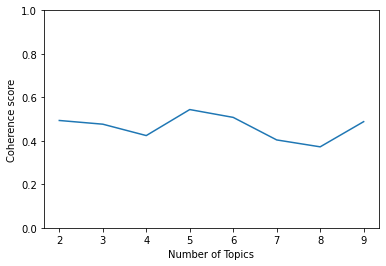

In [345]:
%%time
# determine optimal number of topics using coherence score:
coherence_vals = []
model_list =[]
start = 2
stop = 10
step = 1
random_state = 20

for num_topics in range(start, stop, step):
    # make LDa model and calc coherence:
    model = LdaModel(corpus=tfidf_corpus, id2word=id2word, num_topics=num_topics, passes=4, iterations=150, 
                     random_state=random_state
                    )
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v', processes=4)
    coherence_vals.append(coherence_model.get_coherence())
    
x = range(start, stop, step)
plt.plot(x, coherence_vals)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.ylim([0, 1]);

In [346]:
best_model = model_list[coherence_vals.index(max(coherence_vals))]
print(f"Best model coherence score is {max(coherence_vals):0.3f}")

Best model coherence score is 0.544


In [347]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_model, tfidf_corpus, id2word, sort_topics=False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.009170 -0.032030       1        1   7.062841
1     -0.042777  0.004260       2        1  75.421084
2      0.022179 -0.019081       3        1   6.405256
3     -0.027496  0.013919       4        1   7.847889
4      0.038925  0.032932       5        1   3.262930, topic_info=                  Term       Freq      Total Category  logprob  loglift
2067        accounting  13.000000  13.000000  Default  30.0000  30.0000
1136        restaurant   8.000000   8.000000  Default  29.0000  29.0000
220          financial  15.000000  15.000000  Default  28.0000  28.0000
97    machine_learning  18.000000  18.000000  Default  27.0000  27.0000
1970           account   9.000000   9.000000  Default  26.0000  26.0000
...                ...        ...        ...      ...      ...      ...
125              place   0.462907   6.469120   Topic5  -6.7419   0.7853
1277             shift   0.430363   2.811410   Topic5  -6.8148   1.5457
675           everyone   0.439278   7.506464   Topic5  -6.7943   0.5842
453           location   0.421879   7.923835   Topic5  -6.8347   0.4896
251            mission   0.418644   8.802774   Topic5  -6.8424   0.3767

[343 rows x 6 columns], token_table=      Topic      Freq                   Term
term                                        
3390      3  0.909243           accept_third
914       2  0.849110             accessible
3391      3  0.909251  accommodation_flights
1970      1  0.319524                account
1970      2  0.532540                account
...     ...       ...                    ...
2640      3  0.544811                  water
3433      3  0.909193  work_environment_rich
3736      1  0.736173         working_papers
3105      1  0.392467               year_end
3105      2  0.392467               year_end

[452 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

Wall time: 1.17 s


,topic_1,topic_2,topic_3,topic_4,topic_5
0,0.007*accounting,0.002*product,0.003*construction,0.003*machine_learning,0.006*chipotle
1,0.004*account,0.002*client,0.003*mcelhanney,0.003*model,0.004*restaurant
2,0.003*financial,0.002*analytics,0.002*water,0.003*security,0.003*food
3,0.003*accountant,0.002*analyst,0.002*design,0.002*customer,0.002*panda
4,0.003*finance,0.002*project,0.002*civil_engineering,0.002*science,0.002*kitchen
5,0.002*monthly,0.002*research,0.002*project,0.002*scientist,0.002*real_food
6,0.002*assist,0.002*model,0.002*civil,0.002*ai,0.002*food_accessible
7,0.002*prepare,0.002*machine_learning,0.002*client,0.002*software,0.002*cultivating_better_world
8,0.002*reconciliation,0.002*analysis,0.002*land_development,0.002*design,0.002*crew
9,0.002*preparation,0.002*insight,0.002*engineering,0.002*engineering,0.002*continue


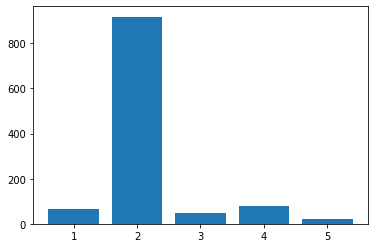

In [360]:
%%time
# display topics:
topics = best_model.print_topics(num_words=10)
topics_df = pd.DataFrame(topics)
topics_df = topics_df[1].str.replace("\\s\\+", "", regex=True).str.replace('\\"', "").str.split(" ", expand=True).T
topics_df.columns = [f"topic_{t+1}" for t in topics_df.columns]

doc_topics = np.argmax(gensim.matutils.corpus2csc(best_model.get_document_topics(tfidf_corpus)).toarray(), axis=0)
plt.bar(height=np.bincount(doc_topics), x=list(range(1, best_model.num_topics+1)));
    
topics_df

# Lessons Learned

- Using TF-IDF versus just TF increased coherence score and seemed to increase interpretability in topics
- Using bi- and tr- grams improved coherence score, as well as tuning the threshold parameters
- Increasing LDA passes > 4 increases coherence and interpretability, but passes = 10 seems to overfit the data and the topics end up being specific to companies (i.e., topic words are bell, microsoft, rogers, etc.
- Coherence score cannot be relied on completely, sometimes the topics are not great, or the best model may not include a topic I know is there (i.e., Civil Engineering, which I purposely put in, around 11% of total dataset).

# Observations

Improved model coherence score and subjective results by using TF-IDF, decreasing the bi- and tri-gram model parameters, increasing passes and iterations of LDA model. LDA model seems to be able to tease out the major topics, which seem possible:<br>
1. Accountant
2. Data Analyst (Product or Client)
3. Civil Engineer
4. Data Scientist (more ML/AI and SWE)
5. Restaurant
<br>
It is interesting that the model seems to seperate Data Analyst and Data Scientist, even though they have a lot of overlap. I was hoping that the model would be able to seperate these two considering the job desctiptions can be very similar but they are actually different roles.

<br><br>
Further Research<br>
Look into whether the job title matches the topics produced using the LDA model.